In [2]:
import pandas as pd
import numpy as np
import json

from traffic.analysis_utils import calc_mean_velocity, density_running_avg, calc_density, flow_rate_running_avg, \
    calc_flow_rate

In [2]:
experiment = "experiment-traffic-lights"

### Reading input data

In [3]:
with open(f'traffic/input_files/{experiment}/traffic.json', "r") as read_file:
    drivers_input_data = json.load(read_file)
with open(f'traffic/input_files/{experiment}/drivers.json', "r") as read_file:
    traffic_input_data = json.load(read_file)
with open(f'traffic/input_files/{experiment}/lights.json', "r") as read_file:
    lights_input_data = json.load(read_file)

### Reading output data

In [15]:
agent_data = pd.read_csv(f'traffic/output_files/{experiment}/agent_data.csv')
agent_data["Velocity"] = agent_data["Velocity"].apply(lambda x: float(x.split(" ")[0].replace("[","")))
agent_data["Velocity"] = agent_data["Velocity"].astype(float)
agent_data.head()

,Step,AgentID,X,Y,Velocity,Current_lane,Is_alive
0,1,0,1.287103,166.666667,1.287103,2,True
1,1,1,1.221292,100.000000,1.221292,1,True
2,1,2,0.000000,166.666667,1.358701,2,False
3,1,3,0.000000,166.666667,1.348567,2,False
4,1,4,0.000000,166.666667,1.346939,2,False


## Flow rate

#### Flow rate: The flow rate is the number of cars that pass a certain point per unit of time.

In [5]:
nodes = []
for node in lights_input_data:
    nodes.append(node["pos"])
print("The x positions of nodes:")
print(nodes)

The x positions of nodes:
[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]


In [8]:
t_start = 851
t_end = 5589
measure_point_x = 500
accepted_dist_delta = 10

fr = calc_flow_rate(
                df = agent_data,
                t_start = t_start,
                t_end = t_end,
                measure_point_x = measure_point_x,
                accepted_dist_delta = accepted_dist_delta)

print("flow rate = ",fr)
print(f"Between {t_start} and {t_end} timestamps, there was {fr} cars at point {measure_point_x} with rounding to {accepted_dist_delta}")


flow rate =  20
Between 851 and 5589 timestamps, there was 20 cars at point 500 with rounding to 10


In [9]:
## Rolling average 

flow_rate_running_avg(agent_data,851,5589,500,1000,1000)

12.263157894736842

## Density
#### Density: Traffic density is the number of cars per unit length of the road at any instant. 

In [10]:
x_start = 500
x_end = 600
time = 2000

d = calc_density(agent_data,x_start,x_end,time)

# density at time 2000 between  two given nodes (their x_positions)
print(f"The number of cars between pos_x {x_start} and {x_end}, at time {time}, divided by the distance of {x_end-x_start} is equal {d}")

The number of cars between pos_x 500 and 600, at time 2000, divided by the distance of 100 is equal 0.01


In [11]:
# rolling average

#running average for the same two nodes, using time range, not specific timestamp this time, the result should be simmilar
density_running_avg(agent_data,500,600,851,5589)

0.0063080168776371215

## Velocity

**Velocity: Average velocity of agents between two nodes in some time window**

In [12]:
t_start = 851
t_end = 5589
x_start = 500
x_end = 600

velocities_per_agent = calc_mean_velocity(agent_data, 851, 5589, 500, 600)
print(velocities_per_agent)

0.9336260334209313


In [13]:
np.mean(agent_data.loc[agent_data["Is_alive"]==True 
               & (agent_data['X']>x_start) 
               & (agent_data["X"]<x_end)
               & (agent_data["Step"]>t_start)
               & (agent_data["Step"]>t_end)]["Velocity"])



0.9336260334209313

### Can I make a running average for velocity?

## Making a dataframe that collects the parameters and results of experiments we run? 

In [ ]:
import pandas as pd

agent_data = pd.read_csv(f'traffic/output_files/{experiment}/agent_data.csv')
agent_data["Velocity"] = agent_data["Velocity"].apply(lambda x: float(x.split(" ")[0].replace("[","")))
agent_data["Velocity"] = agent_data["Velocity"].astype(float)

t_start = 851
t_end = 5589
x_start = 500
x_end = 600
time = 2000
measure_point_x = 500
accepted_dist_delta = 10
running_step = 333
window_size = 1000

#experiment_results = pd.DataFrame(columns=['experiment', 'average_velocity', 'rolling_average_density', 'rolling_average_flow'])

experiment_results = pd.read_csv('experiment_results.csv')

def collect_data(agent_data, t_start, t_end, x_start, x_end, running_step, measure_point_x, accepted_dist_delta, window_size):
    
    data = {
        'experiment': experiment,
        'average_velocity': calc_mean_velocity(agent_data, t_start, t_end, x_start, x_end),
        'rolling_average_density': density_running_avg(x_start, x_end, t_start, t_end, running_step=5),
        'rolling_average_flow': flow_rate_running_avg(t_start, t_end, measure_point_x, accepted_dist_delta, window_size, running_step=100)
    }
     
    experiment_results.loc[len(experiment_results)] = data

# Call collect_data function to update experiment_results
collect_data(agent_data, t_start, t_end, x_start, x_end, running_step, measure_point_x, accepted_dist_delta, window_size)

# Save experiment_results as a CSV file
experiment_results.to_csv('experiment_results.csv', index=False)


# Making plots from a series of experiments

In [32]:
experiment_results = pd.read_csv("collected_experiment_results.csv")
experiment_results

,n_agents,max_speed_avg,max_speed_dev,desired_distance_avg,desired_distance_dev,acceleration_avg,acceleration_dev,n_lanes,t_start,t_end,x_start,x_end,measure_point_x,accepted_dist_delta,window_size,average_velocity,rolling_average_density,rolling_average_flow
0,50,0.75,0.4,30,0,1.5,0.3,3,476,2492,500,600,500,10,100,1.351948,0.049752,3.350000
1,50,1.00,0.4,30,0,1.5,0.3,3,4336,5810,500,600,500,10,100,1.368288,0.043525,4.428571
2,50,1.25,0.4,30,0,1.5,0.3,3,7223,8566,500,600,500,10,100,1.372670,0.032528,4.076923
3,50,1.50,0.4,30,0,1.5,0.3,3,9538,10632,500,600,500,10,100,1.369946,0.033151,5.300000
4,50,1.75,0.4,30,0,1.5,0.3,3,11391,12421,500,600,500,10,100,1.362210,0.029710,5.200000
5,50,2.00,0.4,30,0,1.5,0.3,3,13027,14087,500,600,500,10,100,1.349085,0.023850,5.000000
6,50,0.75,0.4,30,0,1.5,0.3,3,512,2507,500,600,500,10,100,1.344190,0.044400,3.368421
7,50,1.00,0.4,30,0,1.5,0.3,3,4330,5728,500,600,500,10,100,1.360570,0.047429,4.846154
8,50,1.25,0.4,30,0,1.5,0.3,3,7108,8272,500,600,500,10,100,1.365298,0.036781,4.454545
9,50,1.50,0.4,30,0,1.5,0.3,3,9333,10241,500,600,500,10,100,1.363862,0.041374,6.111111


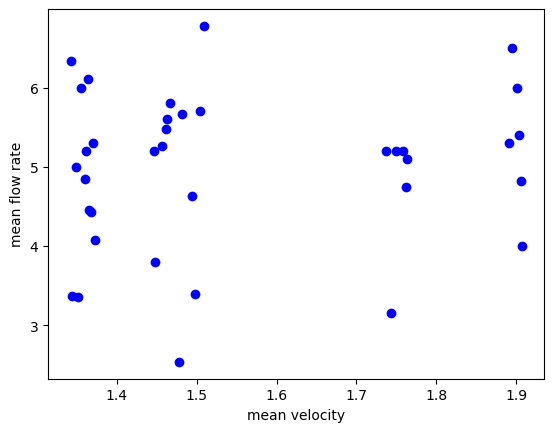

In [33]:
import matplotlib.pyplot as plt

# Create a new figure and axis
fig, ax = plt.subplots()

ax.scatter(experiment_results['average_velocity'], 
           experiment_results['rolling_average_flow'], 
           color='blue')

# Add labels and legend
ax.set_xlabel('mean velocity')
ax.set_ylabel('mean flow rate')
# ax.legend()

# Display the plot
plt.show()

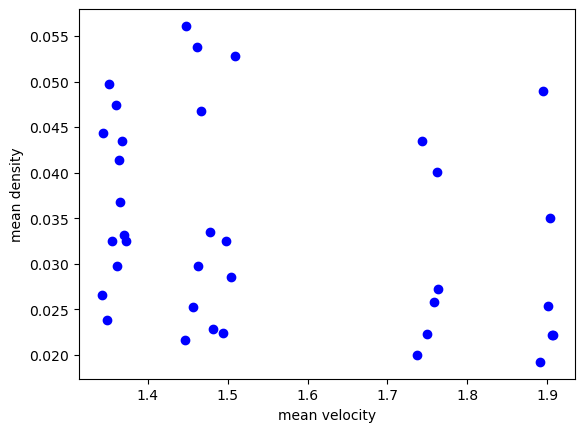

In [34]:
# Create a new figure and axis
fig, ax = plt.subplots()

ax.scatter(experiment_results['average_velocity'], 
           experiment_results['rolling_average_density'], 
           color='blue')

# Add labels and legend
ax.set_xlabel('mean velocity')
ax.set_ylabel('mean density')
# ax.legend()

# Display the plot
plt.show()

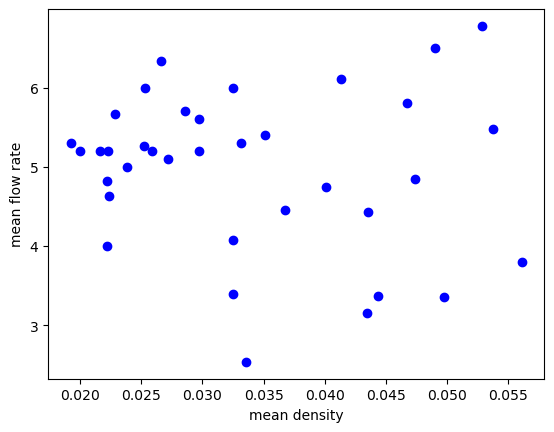

In [35]:
# Create a new figure and axis
fig, ax = plt.subplots()

ax.scatter(experiment_results['rolling_average_density'], 
           experiment_results['rolling_average_flow'], 
           color='blue')

# Add labels and legend
ax.set_xlabel('mean density')
ax.set_ylabel('mean flow rate')
# ax.legend()

# Display the plot
plt.show()